In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


Визначаємо функцію для виміру метрик.

In [3]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

Загружаємо дані з файлу.

In [4]:
series = pd.read_csv('cardox.csv', index_col='date')
series

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


Перевіряємо розмірнісь та на наявність пропущених значень.

In [5]:
series.isna().sum()

value    0
dtype: int64

In [6]:
series.shape

(729, 1)

In [7]:
series.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


Візуалізація данних.

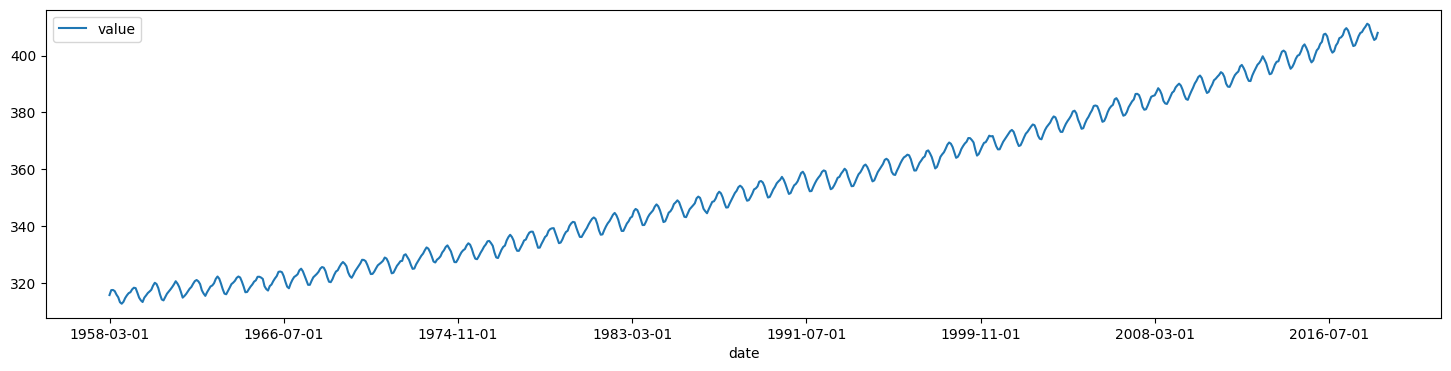

In [8]:
plt.rcParams['figure.figsize']=[18,4]
series.plot()
plt.show()

З даного графіка видно, що є трендовість та сезонність. Для кращого аналізу даних зробимо декомпозицію даних.

Text(0.5, 0.98, 'Мультиплікативна декомпозиція')

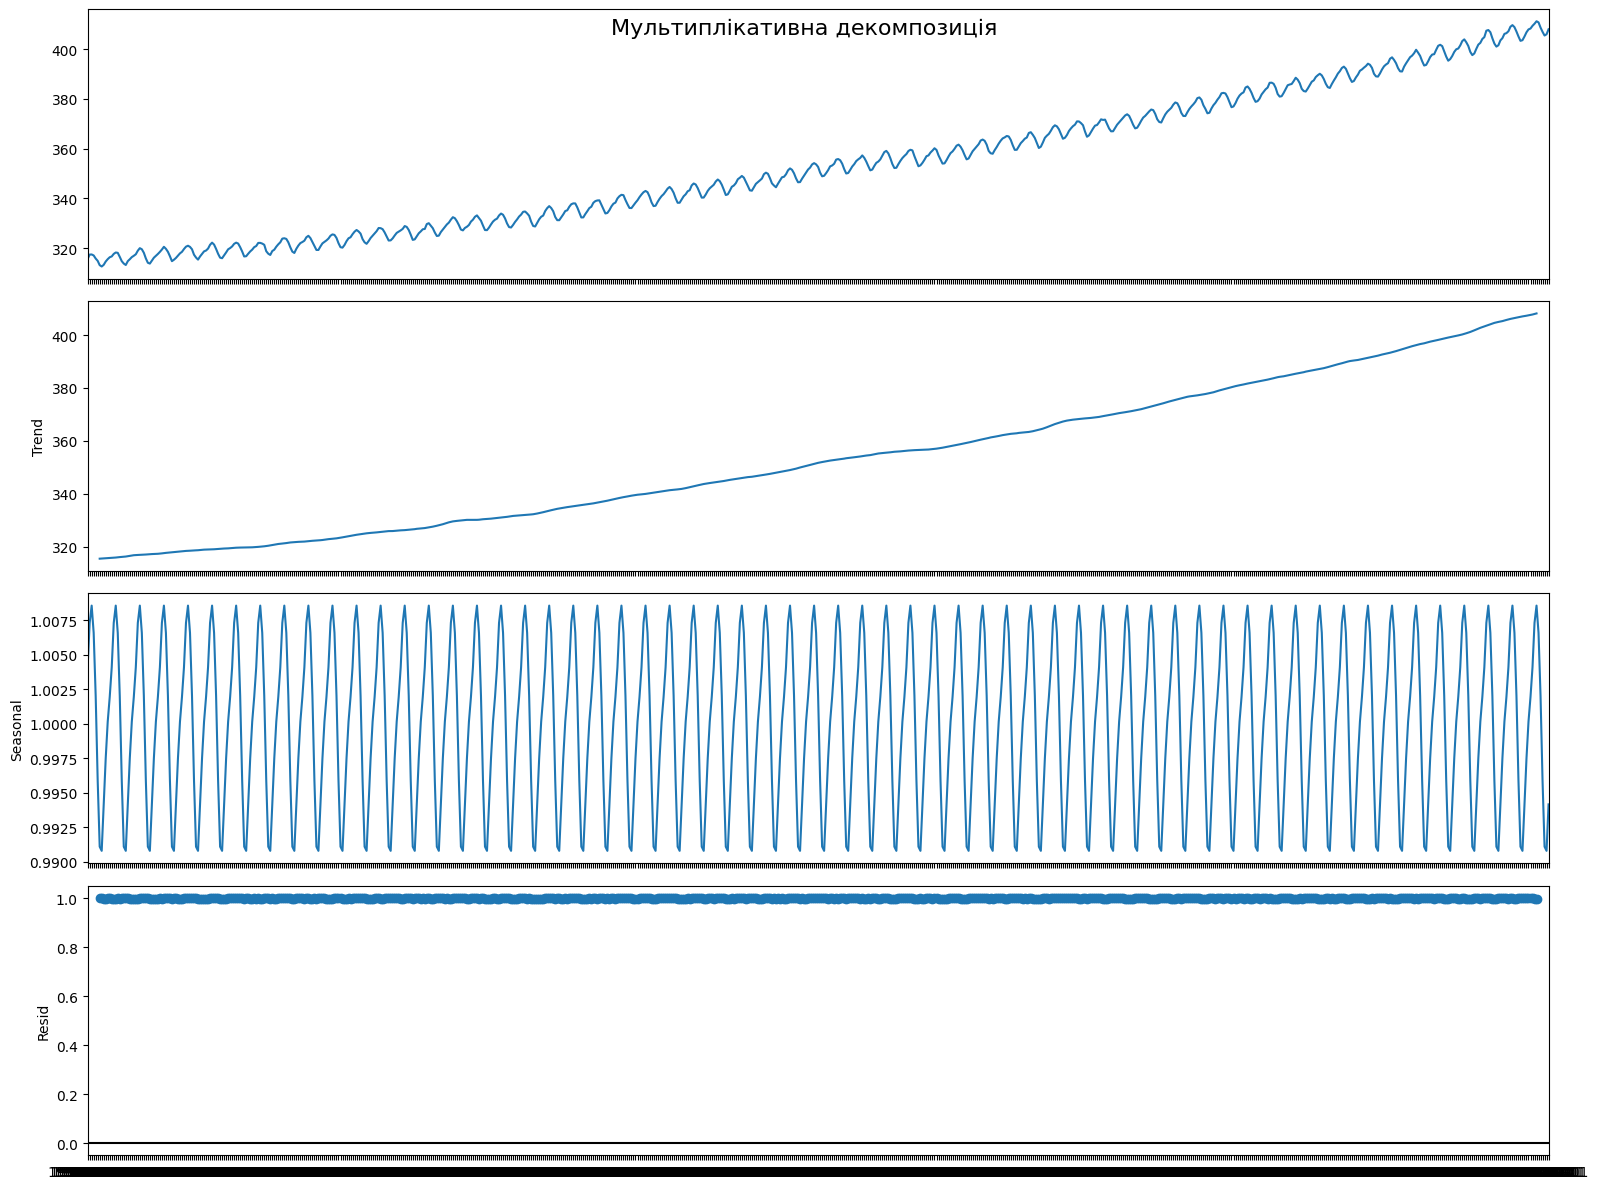

In [9]:
multiplicative_decomposition = seasonal_decompose(series, model='multiplicative', period=12)



# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Мультиплікативна декомпозиція', fontsize=16)


__На основі декомпозиції можно зробити висновок що, є чітка трендовість та сезонність, екзогених викиді немає.__

Отже для прогнозування данних можемо використати модель SARIMA.

Розбиваємо на тренеровочну та тестові вибірки. Та візуалізуємо їх.


In [10]:
series.index = pd.to_datetime(series.index, format='%Y-%m-%d')
split_date = pd.to_datetime("2008-01-01", format='%Y-%m-%d')

train = series[series.index <= split_date]
test = series[series.index > split_date]

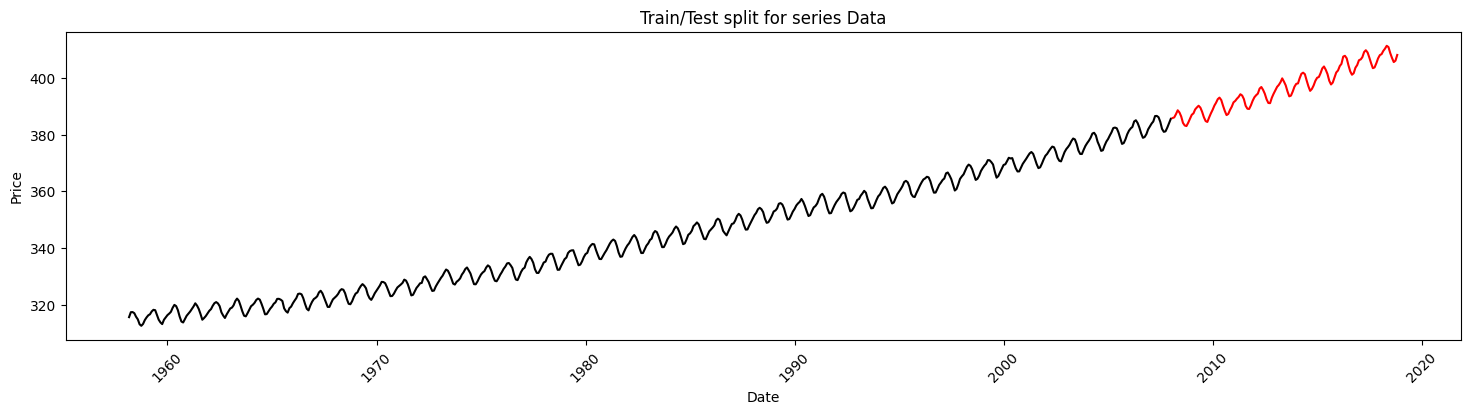

In [11]:
plt.rcParams['figure.figsize']=[18,4]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for series Data")
plt.show()

Для пошуку гіперпараметрів використовую AUTO_ARIMA.

In [12]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=378.498, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1927.353, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1285.693, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1930.909, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=610.861, Time=0.91 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=384.938, Time=7.15 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=403.419, Time=2.74 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1143.253, Time=0.38 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=470.514, Time=2.32 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=379.525, Time=2.52 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=348.644, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AI

Навчаємо модель та робимо прогноз на тестову вибірку та порівнюємо їх

In [22]:
SARIMAXmodel = sm.tsa.statespace.SARIMAX(train, order = (0,1,1), seasonal_order=(1,0,1,12))
SARIMAXmodel = SARIMAXmodel.fit()


y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.1) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
y_pred_out

c:\Users\48513\PycharmProjects\DZ_pds7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\48513\PycharmProjects\DZ_pds7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


date
2008-02-01    386.200089
2008-03-01    387.051130
2008-04-01    388.474367
2008-05-01    388.853246
2008-06-01    388.312801
                 ...    
2018-07-01    405.915674
2018-08-01    403.847015
2018-09-01    402.325775
2018-10-01    402.499249
2018-11-01    403.858300
Name: Predictions, Length: 130, dtype: float64

Будуємо графік та обчислюємо метрики.

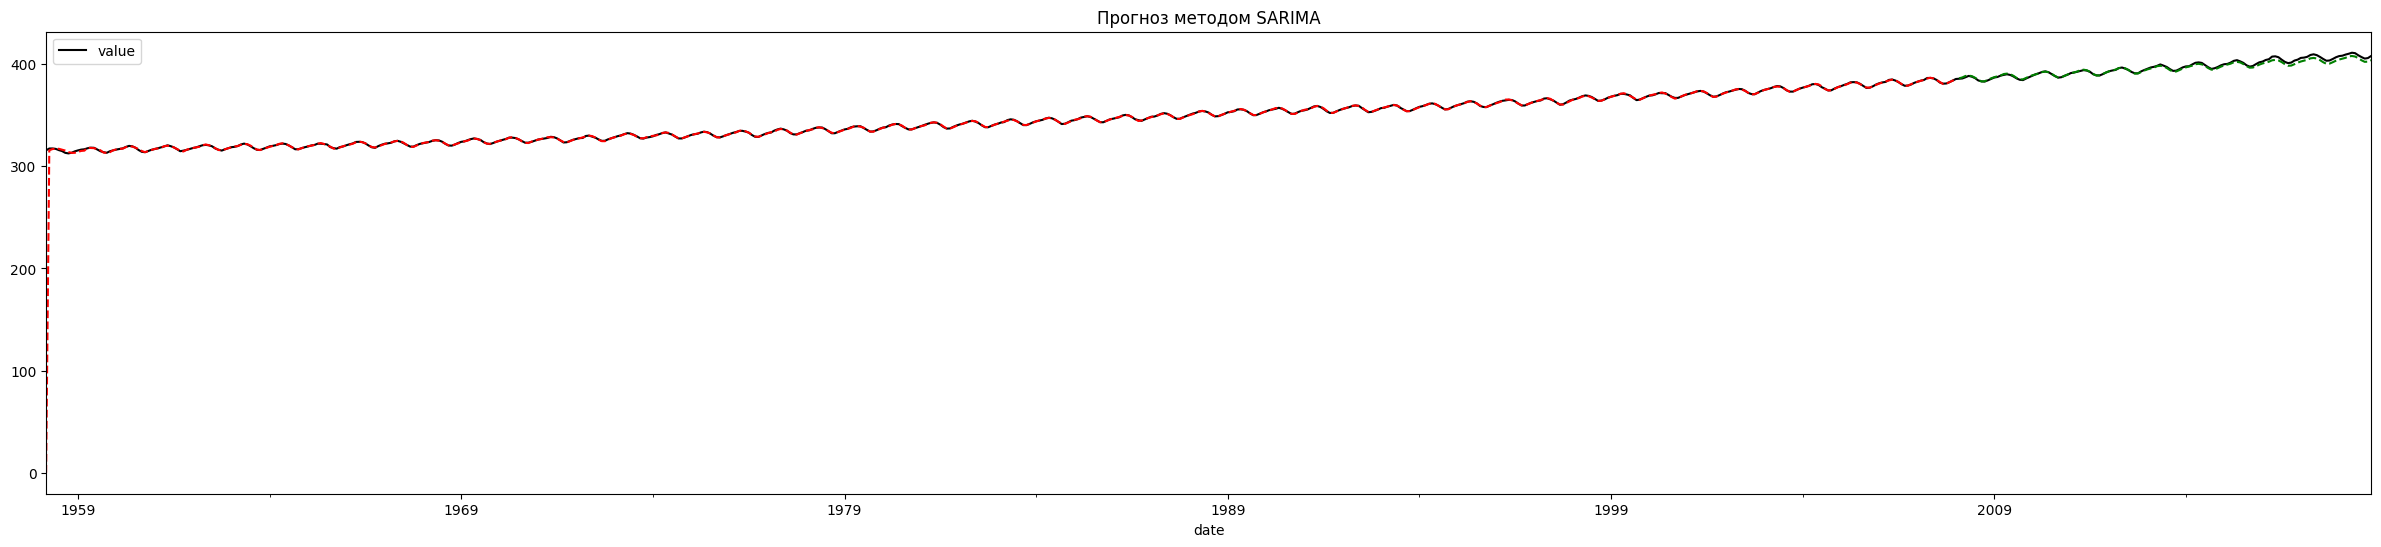

In [14]:
ax = series.plot(figsize=(30,6), color='black', title="Прогноз методом SARIMA" )
SARIMAXmodel.fittedvalues.plot(ax=ax, style='--', color='red')
y_pred.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [15]:
metrics(test, y_pred_out)

Тест на стаціонарність:
	T-статистика = 0.329
	P-значення = 0.979
Критичне значення :
	1%: -3.484219653271961 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.885145235641637 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.579359138917794 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 1.2831
MSE: 3.0491
MAPE: 0.0032
MPE: 0.0025
Стандартна похибка: 1.7462


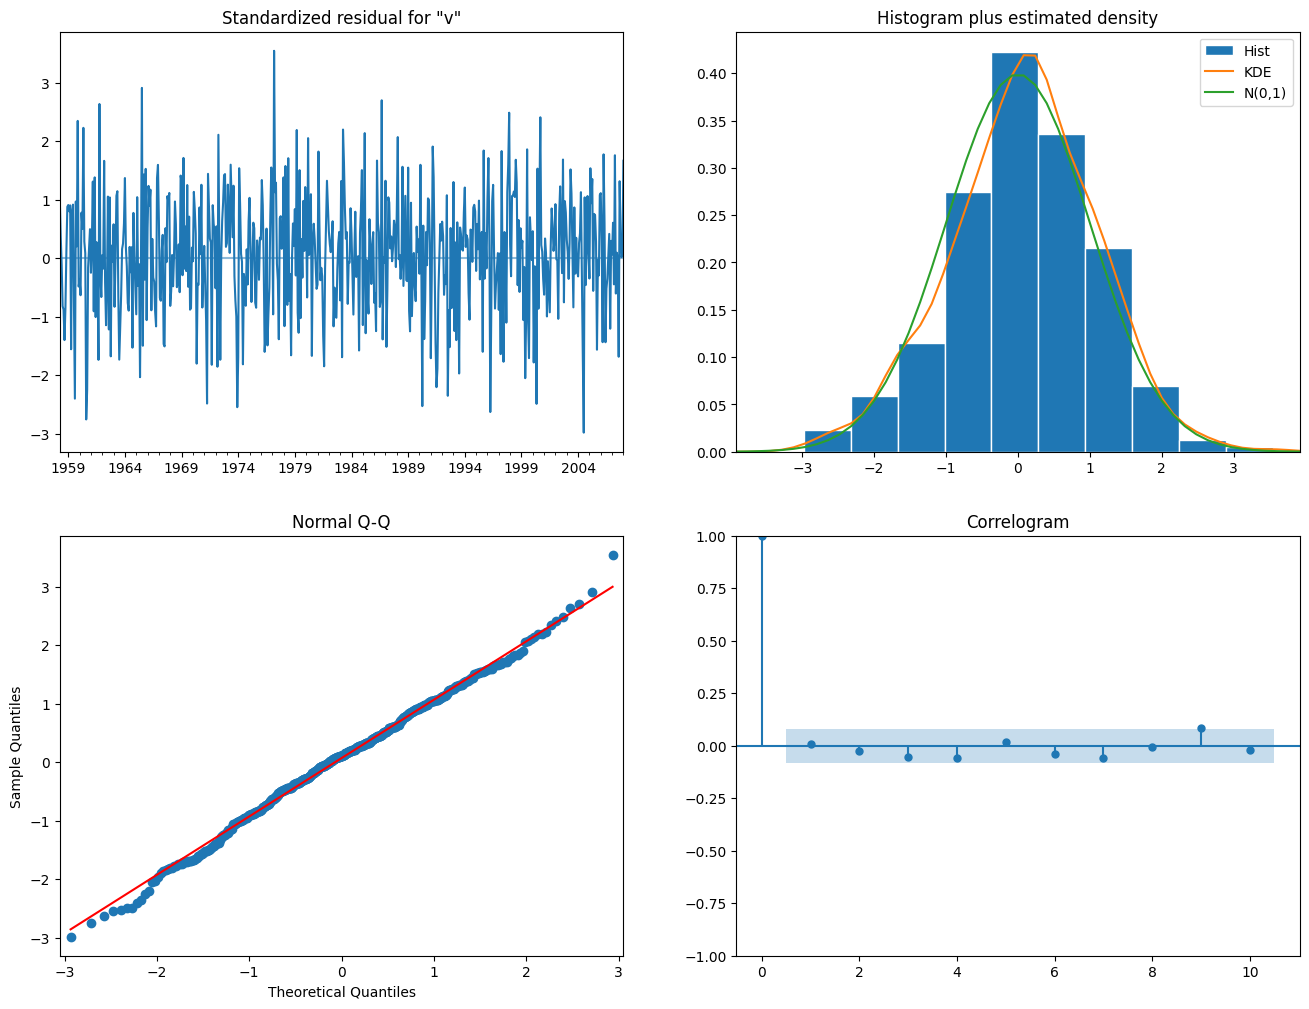

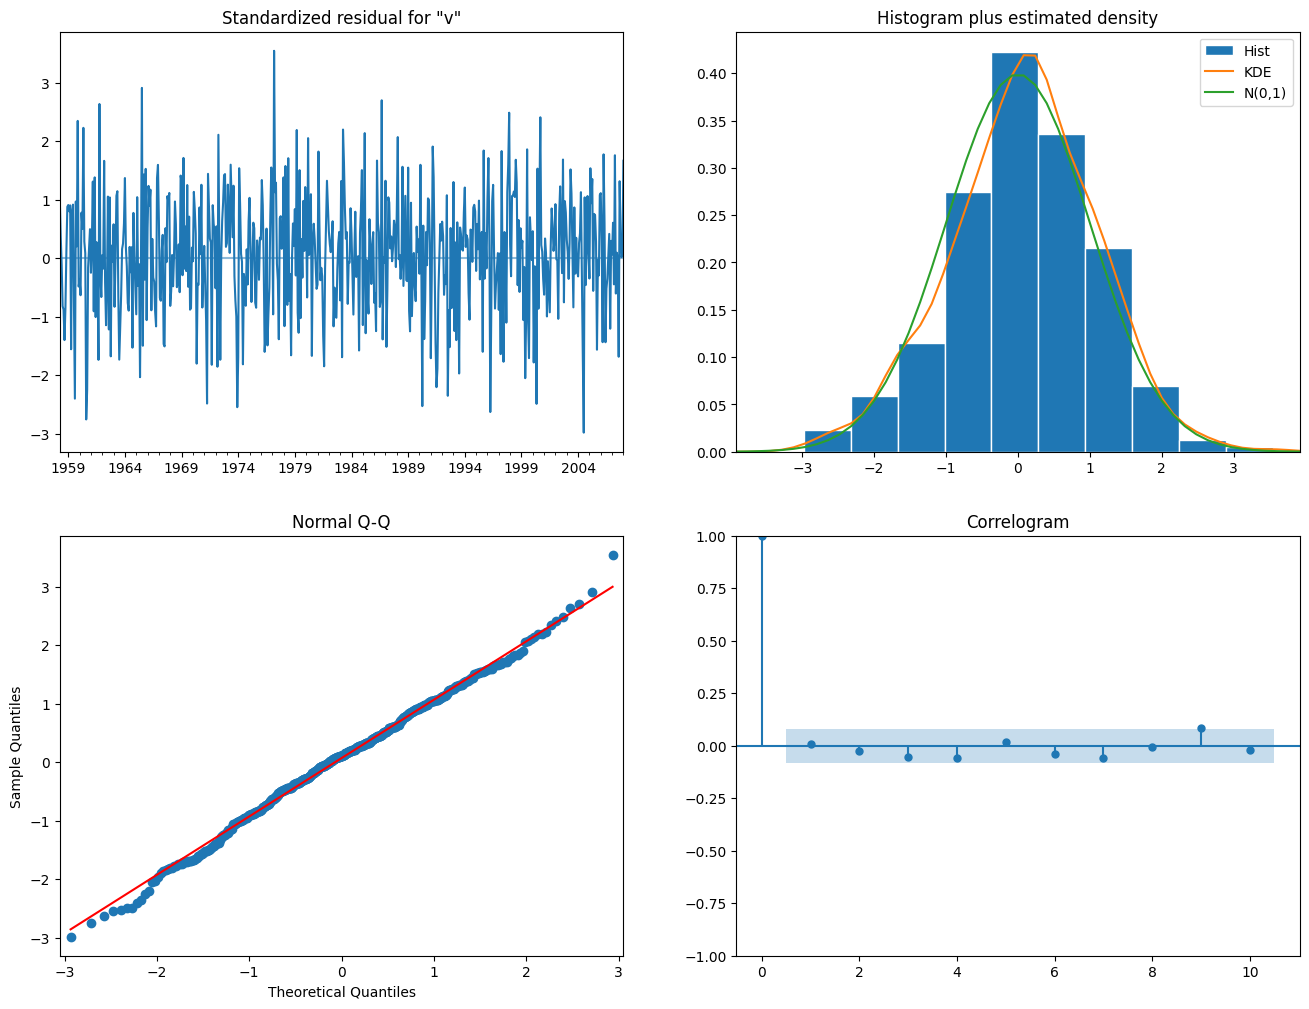

In [16]:
plot_diagnostik = SARIMAXmodel.plot_diagnostics(figsize=(16,12))
plot_diagnostik

Робимо прогноз на наступні 30 років. Та будуємо графік з довірчими інтервалими.

In [17]:
predict = SARIMAXmodel.get_prediction(start='2019-01-01', end='2048-01-01')
pred_conf = predict.conf_int()

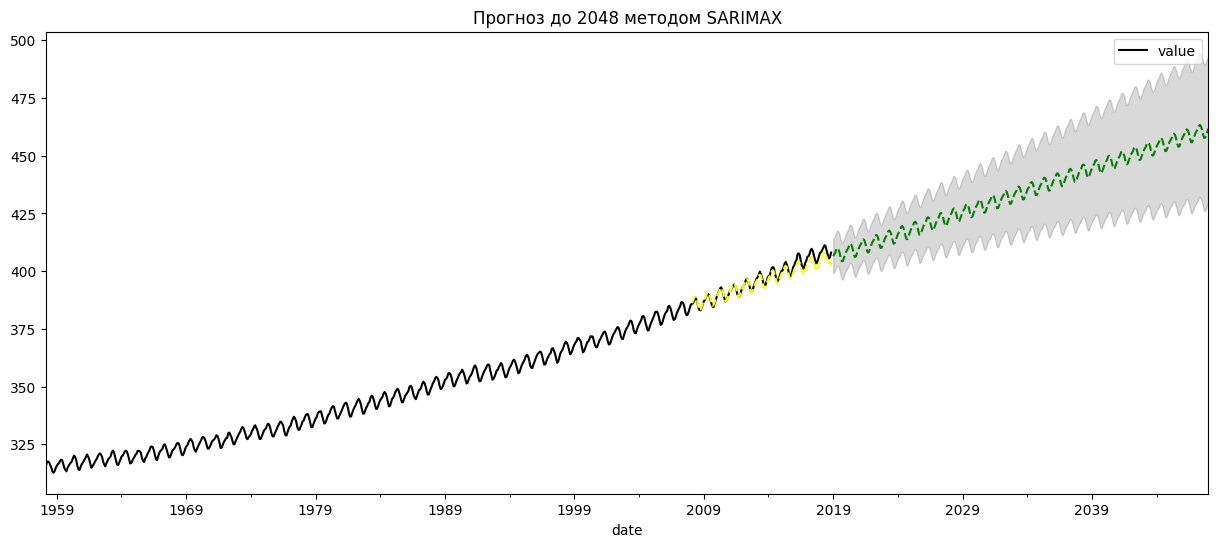

In [18]:
ax = series.plot(figsize=(15,6), color='black',label='Відомі', title='Прогноз до 2048 методом SARIMAX')
y_pred.predicted_mean.plot(ax=ax, style='--', color='yellow')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
ax.fill_between(predict.predicted_mean.index,
pred_conf.iloc[:, 0],
pred_conf.iloc[:, 1], color='k', alpha=.15)
plt.show()



___Висновок: Отже бачимо що данна модель доволі точно прогнозує майбутні данні, про що свідчать маленькі показники метрик, зокрема стандартної похибки.___

In [19]:
forecast_data = pd.DataFrame(predict.predicted_mean)
forecast_data.to_csv('forecast_data.csv')
forecast_data

,predicted_mean
2019-01-01,406.478076
2019-02-01,407.310145
2019-03-01,408.158205
2019-04-01,409.576457
2019-05-01,409.954010
...,...
2047-09-01,457.671759
2047-10-01,457.843636
2047-11-01,459.190175
2047-12-01,460.654609
